# Assignment 8: DT

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# 1.1 Loading Data

In [2]:
project_data = pd.read_csv('../train_data.csv')
resource_data = pd.read_csv('../resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 Preprocessing Categorical Data

### 1.2.1 preprocessing `project_subject_categories`

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [6]:
sorted_cat_dict.keys()

dict_keys(['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language'])

### 1.2.2 preprocessing of `project_subject_subcategories`

In [7]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    sub_cat_list.append(temp.strip())
    
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [8]:
sorted_sub_cat_dict.keys()

dict_keys(['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy'])

### 1.2.3 preprocessing of `School State`

In [9]:
project_data['school_state'].unique()

array(['IN', 'FL', 'AZ', 'KY', 'TX', 'CT', 'GA', 'SC', 'NC', 'CA', 'NY',
       'OK', 'MA', 'NV', 'OH', 'PA', 'AL', 'LA', 'VA', 'AR', 'WA', 'WV',
       'ID', 'TN', 'MS', 'CO', 'UT', 'IL', 'MI', 'HI', 'IA', 'RI', 'NJ',
       'MO', 'DE', 'MN', 'ME', 'WY', 'ND', 'OR', 'AK', 'MD', 'WI', 'SD',
       'NE', 'NM', 'DC', 'KS', 'MT', 'NH', 'VT'], dtype=object)

In [10]:
project_data['school_state'][project_data['school_state'].isnull()==True]

Series([], Name: school_state, dtype: object)

In [11]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())
    
school_state_dict = dict(my_counter)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))

In [12]:
sorted_school_state_dict.keys()

dict_keys(['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA'])

### 1.2.4 preprocessing of `Teacher Prefix`

In [13]:
project_data.groupby(['teacher_prefix'])['teacher_prefix'].count()

teacher_prefix
Dr.           13
Mr.        10648
Mrs.       57269
Ms.        38955
Teacher     2360
Name: teacher_prefix, dtype: int64

In [14]:
project_data['teacher_prefix'][project_data['teacher_prefix'].isnull()==True]

7820     NaN
30368    NaN
57654    NaN
Name: teacher_prefix, dtype: object

In [15]:
project_data['teacher_prefix'].fillna(project_data['teacher_prefix'].mode()[0],inplace=True)

In [16]:
project_data['teacher_prefix'][project_data['teacher_prefix'].isnull()==True]

Series([], Name: teacher_prefix, dtype: object)

In [17]:
project_data['teacher_prefix'].unique()

array(['Mrs.', 'Mr.', 'Ms.', 'Teacher', 'Dr.'], dtype=object)

In [18]:
teacher_prefix = list(project_data['teacher_prefix'].values)

teacher_prefix_list = []
for i in teacher_prefix:
    temp = ""
    temp = i.split('.')
    temp = i.replace('.','')   
    teacher_prefix_list.append(temp)

project_data['clean_teacher_prefix'] = teacher_prefix_list
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_teacher_prefix'].values:
    my_counter.update(word.split())
    
teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))

In [19]:
sorted_teacher_prefix_dict.keys()

dict_keys(['Dr', 'Teacher', 'Mr', 'Ms', 'Mrs'])

In [20]:
project_data.groupby(['clean_teacher_prefix'])['clean_teacher_prefix'].count()

clean_teacher_prefix
Dr            13
Mr         10648
Mrs        57272
Ms         38955
Teacher     2360
Name: clean_teacher_prefix, dtype: int64

### 1.2.5 preprocessing of `Project Grade Category`

In [21]:
project_data.groupby(['project_grade_category'])['project_grade_category'].count()

project_grade_category
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Grades PreK-2    44225
Name: project_grade_category, dtype: int64

In [22]:
project_data['project_grade_category'][project_data['project_grade_category'].isnull()==True]

Series([], Name: project_grade_category, dtype: object)

In [23]:
project_grade_category = list(project_data['project_grade_category'].values)

project_grade_category_list = []
for i in project_grade_category:
    temp = ""
    temp = i.split(' ')
    temp = i.replace('Grades ','')   
    project_grade_category_list.append(temp)

project_data['clean_project_grade_category'] = project_grade_category_list
project_data.drop(['project_grade_category'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())
    
project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

In [24]:
sorted_project_grade_category_dict.keys()

dict_keys(['9-12', '6-8', '3-5', 'PreK-2'])

In [25]:
project_data.groupby(['clean_project_grade_category'])['clean_project_grade_category'].count()

clean_project_grade_category
3-5       37137
6-8       16923
9-12      10963
PreK-2    44225
Name: clean_project_grade_category, dtype: int64

## 1.3 Text Preprocessing of project_essay

In [26]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [27]:
project_data.head(1)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   

  project_submitted_datetime  \
0        2016-12-05 13:43:57   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   

    clean_categories clean_subcategories clean_teacher_prefix  \
0  Literacy_Language        ESL Literacy                  Mrs   

  clean_project_grade_category  \
0                       PreK-2   

                                               essay  
0  My students are English learners that are work...

In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [30]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:22<00:00, 1331.27it/s]


In [34]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

In [35]:
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)

## 1.4 Preprocessing of `project_title`

In [36]:
project_data['project_title'][2000:2010]

2000                    Steady Stools for Active Learning
2001                                   Classroom Supplies
2002    Kindergarten Students Deserve Quality  Books a...
2003                                Listen to Understand!
2004                             iPads to iGnite Learning
2005                                 Tablets For Learning
2006                                             Go P.E.!
2007                                 Making Learning Fun!
2008    Empowerment Through Silk Screen Designed Tee S...
2009                                 Let's Play Together!
Name: project_title, dtype: object

In [37]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 28485.48it/s]


In [38]:
preprocessed_titles[2000:2010]

['steady stools active learning',
 'classroom supplies',
 'kindergarten students deserve quality books vibrant rug',
 'listen understand',
 'ipads ignite learning',
 'tablets for learning',
 'go p e',
 'making learning fun',
 'empowerment through silk screen designed tee shirts',
 'let play together']

In [39]:
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)

 <h2>1.5 Merging Numerical data in Resources to project_data</h2>

In [40]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

<h1>2. Decision Tree </h1>

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   <li><b>Task 2: </b>For this task consider set-1 features. Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [41]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [42]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 20 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    109248 non-null  int64  
 1   id                                            109248 non-null  object 
 2   teacher_id                                    109248 non-null  object 
 3   school_state                                  109248 non-null  object 
 4   project_submitted_datetime                    109248 non-null  object 
 5   project_essay_1                               109248 non-null  object 
 6   project_essay_2                               109248 non-null  object 
 7   project_essay_3                               3758 non-null    object 
 8   project_essay_4                               3758 non-null    object 
 9   project_resource_summary                      10

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - Essay : text data
 
       - quantity : numerical 
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [43]:
data1 = project_data.drop(['Unnamed: 0', 'id','project_submitted_datetime','project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary','teacher_id'], axis = 1)

In [44]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 11 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   school_state                                  109248 non-null  object 
 1   teacher_number_of_previously_posted_projects  109248 non-null  int64  
 2   project_is_approved                           109248 non-null  int64  
 3   clean_categories                              109248 non-null  object 
 4   clean_subcategories                           109248 non-null  object 
 5   clean_teacher_prefix                          109248 non-null  object 
 6   clean_project_grade_category                  109248 non-null  object 
 7   preprocessed_essays                           109248 non-null  object 
 8   preprocessed_titles                           109248 non-null  object 
 9   price                                         10

In [45]:
data1 = data1[:50000]

In [46]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1, data1['project_is_approved'], test_size=0.33, stratify=data1['project_is_approved'])

In [47]:
#Features
X_train.drop(['project_is_approved'], axis=1, inplace=True)

X_test.drop(['project_is_approved'], axis=1, inplace=True)

In [48]:
X_train.head()

school_state  teacher_number_of_previously_posted_projects  \
40589           NC                                            10   
41099           AZ                                             4   
7747            IN                                            34   
1057            OK                                             0   
19857           CA                                             0   

                       clean_categories                   clean_subcategories  \
40589                    History_Civics                        SocialSciences   
41099         Math_Science SpecialNeeds              Mathematics SpecialNeeds   
7747                       Math_Science           AppliedSciences Mathematics   
1057                      Health_Sports                       Health_Wellness   
19857  History_Civics Literacy_Language  History_Geography Literature_Writing   

      clean_teacher_prefix clean_project_grade_category  \
40589                  Mrs                          6-8   
41099                  Mrs                          3-5   
7747                   Mrs                       PreK-2   
1057                   Mrs                       PreK-2   
19857                   Ms                          3-5   

                                     preprocessed_essays  \
40589  my students day residential students located d...   
41099  our classroom place joy learning instilled eve...   
7747   my kindergarten students enthusiastic school n...   
1057   i teach group wiggly second graders they great...   
19857  my students come high risk high poverty commun...   

                                    preprocessed_titles   price  quantity  
40589                               supplying education  113.01       159  
41099                            making math meaningful  348.70        20  
7747   chromebook a computer prepare my students future  438.78         1  
1057                         getting kore focus problem  178.47        15  
19857              4th grade california mission project  336.38        13

<h2>2.2 Make Data Model Ready: encoding essay, and project_title</h2>

In [49]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

#### Encoding Essay and Project title

    2.2.1 TFIDF
    2.2.2 TFIDF W2V

### 2.2.1 TF IDF Essay and Title

##### 2.2.1.1 TF IDF Essay

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)



(33500, 10) (33500,)
(16500, 10) (16500,)
After vectorizations
(33500, 35439) (33500,)
(16500, 35439) (16500,)


##### 2.2.1.2 TF IDF Title

In [51]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['preprocessed_titles'].values)
X_test_title_tfidf = vectorizer.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)


(33500, 10) (33500,)
(16500, 10) (16500,)
After vectorizations
(33500, 9707) (33500,)
(16500, 9707) (16500,)


### 2.2.2 TF IDF W2V Essay and Title

##### 2.2.2.1 TF IDF W2V Essay

In [52]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('../glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [53]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [54]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|██████████| 33500/33500 [01:27<00:00, 381.72it/s]

33500
300


In [55]:
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

100%|██████████| 16500/16500 [00:47<00:00, 346.57it/s]


##### 2.2.2.2 TF IDF W2V Title

In [56]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [57]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train_title.append(vector)

print(len(tfidf_w2v_vectors_train_title))
print(len(tfidf_w2v_vectors_train_title[0]))

100%|██████████| 33500/33500 [00:01<00:00, 22967.68it/s]

33500
300


In [58]:
tfidf_w2v_vectors_test_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test_title.append(vector)

100%|██████████| 16500/16500 [00:00<00:00, 20628.35it/s]


<h2>2.3 Make Data Model Ready: encoding numerical, categorical features</h2>

In [59]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 2.3.1 Numerical features

    1. teacher_number_of_previously_posted_projects
    2. price
    3. quantity

##### 2.3.1.1 Teacher number of previously posted projects

In [60]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_TPPP_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_TPPP_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_TPPP_norm.shape, y_train.shape)
print(X_test_TPPP_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)


In [61]:
print("Transpose of teacher number of previously posted projects")

X_train_TPPP_norm = X_train_TPPP_norm.transpose()
X_test_TPPP_norm = X_test_TPPP_norm.transpose()

print("After transpose")
print(X_train_TPPP_norm.shape, y_train.shape)
print(X_test_TPPP_norm.shape, y_test.shape)
print("="*100)

Transpose of teacher number of previously posted projects
After transpose
(33500, 1) (33500,)
(16500, 1) (16500,)


##### 2.3.1.2 price

In [62]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)


In [63]:
print("Transpose of price")

X_train_price_norm = X_train_price_norm.transpose()
X_test_price_norm = X_test_price_norm.transpose()


print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

Transpose of price
After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


##### 2.3.1.3 quantity

In [64]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)


In [65]:
print("Transpose of Quantity")

X_train_quantity_norm = X_train_quantity_norm.transpose()
X_test_quantity_norm = X_test_quantity_norm.transpose()


print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

Transpose of Quantity
After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 2.3.2 Categorical Data

#### Categorical Features for vectorization

    1. Clean Categories
    2. Clean Sub Categories
    3. School State
    4. Teacher Prefix
    5. Project grade category

##### 2.3.2.1 Clean Categories 

In [66]:
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_CC_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_CC_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_CC_ohe.shape, y_train.shape)
print(X_test_CC_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(33500, 9) (33500,)
(16500, 9) (16500,)
['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


##### 2.3.2.2 Clean Sub Categories 

In [67]:
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_CSC_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_CSC_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_CSC_ohe.shape, y_train.shape)
print(X_test_CSC_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(33500, 30) (33500,)
(16500, 30) (16500,)
['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


##### 2.3.2.3 School State

In [68]:
vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)
['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


##### 2.3.2.4 Teacher prefix

In [69]:
vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['clean_teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['clean_teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)
['Dr', 'Teacher', 'Mr', 'Ms', 'Mrs']


##### 2.3.2.5 Project Grade category

In [70]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['clean_project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['clean_project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)
['9-12', '6-8', '3-5', 'PreK-2']


### Concatinating all the features

##### 1. SET 1 TF IDF

In [71]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_TFIDF = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_CSC_ohe, X_train_CC_ohe, X_train_price_norm, X_train_quantity_norm, X_train_TPPP_norm)).tocsr()
X_te_TFIDF = hstack((X_test_essay_tfidf, X_test_title_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_CSC_ohe, X_test_CC_ohe, X_test_price_norm, X_test_quantity_norm, X_test_TPPP_norm)).tocsr()

print("Final Data matrix")
print(X_tr_TFIDF.shape, y_train.shape)
print(X_te_TFIDF.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 45248) (33500,)
(16500, 45248) (16500,)


##### 2. SET 2 TF IDF W2V

In [72]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_TFIDF_W2V = hstack((tfidf_w2v_vectors_train, tfidf_w2v_vectors_train_title, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_CSC_ohe, X_train_CC_ohe, X_train_price_norm, X_train_quantity_norm, X_train_TPPP_norm)).tocsr()
X_te_TFIDF_W2V = hstack((tfidf_w2v_vectors_test, tfidf_w2v_vectors_test_title, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_CSC_ohe, X_test_CC_ohe, X_test_price_norm, X_test_quantity_norm, X_test_TPPP_norm)).tocsr()

print("Final Data matrix")
print(X_tr_TFIDF_W2V.shape, y_train.shape)
print(X_te_TFIDF_W2V.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 702) (33500,)
(16500, 702) (16500,)


<h2>2.4 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [73]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 2.4.1 Applying Descision Tree on TFIDF,<font color='red'> SET 1</font>

In [74]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sea

#best depth in range [1, 5, 10, 50], and the best min_samples_split in range [5, 10, 100, 500]

DT = DecisionTreeClassifier(class_weight = 'balanced')

parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

classifier = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
classifier.fit(X_tr_TFIDF, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [75]:
print(classifier.cv_results_)

{'mean_fit_time': array([ 1.19697762,  1.1872309 ,  1.27083842,  1.18721779,  2.76168402,
        2.83821297,  2.7757384 ,  2.71962905,  6.43627787,  6.79943999,
        5.96889106,  4.94655538, 25.00706434, 24.25506107, 18.65241567,
       11.60350418]), 'std_fit_time': array([1.01216474e-02, 1.89951773e-05, 4.08471086e-02, 2.13544032e-06,
       1.15325652e-02, 1.01782971e-01, 1.05859297e-01, 5.20713854e-02,
       1.47107082e-01, 1.46260285e-01, 2.95122336e-01, 1.51591973e-01,
       2.60197336e-01, 1.74145455e+00, 1.35052353e+00, 1.11017038e+00]), 'mean_score_time': array([0.02083254, 0.01562309, 0.02804812, 0.02083063, 0.02082586,
       0.01907142, 0.02459645, 0.02227068, 0.01561952, 0.02235166,
       0.02365541, 0.01885605, 0.01953435, 0.02080353, 0.02377144,
       0.02252587]), 'std_score_time': array([7.36305444e-03, 3.37174788e-07, 9.12298790e-03, 7.36339162e-03,
       7.36001987e-03, 4.87667141e-03, 6.58673931e-03, 6.58396731e-03,
       6.74349576e-07, 5.79997232e-04, 6.

In [129]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(classifier.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()
max_scores1

mean_fit_time                                \
param_max_depth                    1         5         10        50   
param_min_samples_split                                               
5                            0.120719  0.606974  1.464321  4.590692   
10                           0.143564  0.695861  1.422847  4.148889   
100                          0.177640  0.682927  1.229325  2.486934   
500                          0.131868  0.693345  1.007352  1.175724   

                        std_fit_time                                \
param_max_depth                   1         5         10        50   
param_min_samples_split                                              
5                           0.007324  0.072612  0.119806  0.703576   
10                          0.011753  0.024142  0.013607  0.229554   
100                         0.026490  0.120333  0.058985  0.230739   
500                         0.007017  0.174597  0.077476  0.025724   

                        mean_score_time            ... split2_train_score  \
param_max_depth                      1         5   ...                 10   
param_min_samples_split                            ...                      
5                              0.012531  0.013017  ...           0.801332   
10                             0.010981  0.016029  ...           0.798132   
100                            0.016648  0.013356  ...           0.767585   
500                            0.012315  0.017009  ...           0.740902   

                                  mean_train_score                      \
param_max_depth                50               1         5         10   
param_min_samples_split                                                  
5                        0.998258         0.569785  0.686482  0.801065   
10                       0.991059         0.569785  0.686464  0.797826   
100                      0.887098         0.569785  0.684583  0.771623   
500                      0.780663         0.569785  0.682894  0.741781   

                                  std_train_score                      \
param_max_depth                50              1         5         10   
param_min_samples_split                                                 
5                        0.998276        0.003979  0.002151  0.009203   
10                       0.991074        0.003979  0.002176  0.008458   
100                      0.890015        0.003979  0.002086  0.007859   
500                      0.780041        0.003979  0.001827  0.003619   

                                   
param_max_depth                50  
param_min_samples_split            
5                        0.000292  
10                       0.000351  
100                      0.002240  
500                      0.004248  

[4 rows x 64 columns]

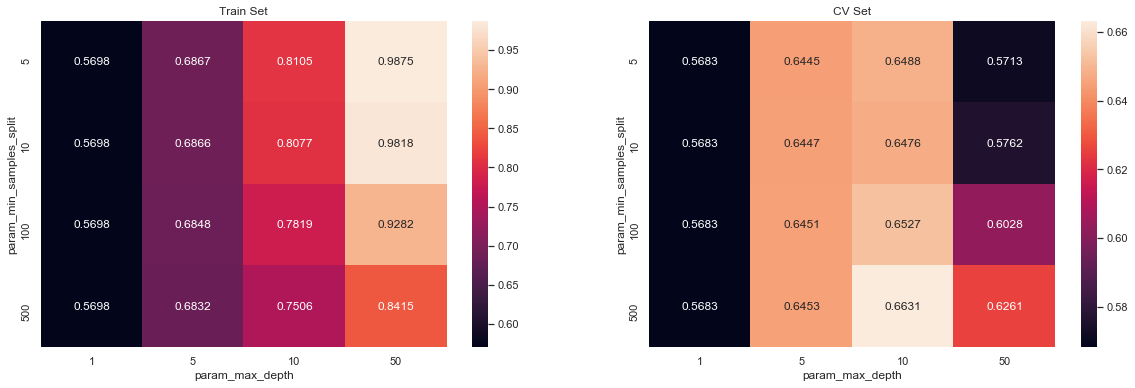

In [77]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [78]:
print(classifier.best_estimator_)
#Mean cross-validated score of the best_estimator
print(classifier.best_params_)
print(classifier.best_score_)
max_d = classifier.best_params_['max_depth']
min_samp_splt = classifier.best_params_['min_samples_split']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'max_depth': 10, 'min_samples_split': 500}
0.6631285546067064


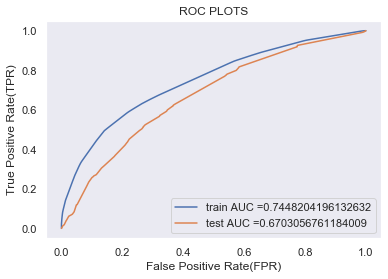

In [146]:
##Fitting Model to Hyper-Parameter Curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
best_clf_TFIDF = DecisionTreeClassifier(class_weight = 'balanced',max_depth=max_d,min_samples_split=min_samp_splt)
best_clf_TFIDF.fit(X_tr_TFIDF ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_clf_TFIDF.predict_proba(X_tr_TFIDF)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_clf_TFIDF.predict_proba(X_te_TFIDF)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.grid(False)
plt.show()

In [147]:
abc = best_clf_TFIDF.predict_proba(X_tr_TFIDF)
abc[:5,:]

array([[0.58975653, 0.41024347],
       [0.70614275, 0.29385725],
       [0.19413914, 0.80586086],
       [0.58975653, 0.41024347],
       [0.34039767, 0.65960233]])

In [148]:
abc = best_clf_TFIDF.predict(X_tr_TFIDF)
abc[:5]

array([0, 0, 1, 0, 1], dtype=int64)

In [149]:
X_train_pred=best_clf_TFIDF.predict(X_tr_TFIDF)
X_test_pred=best_clf_TFIDF.predict(X_te_TFIDF)

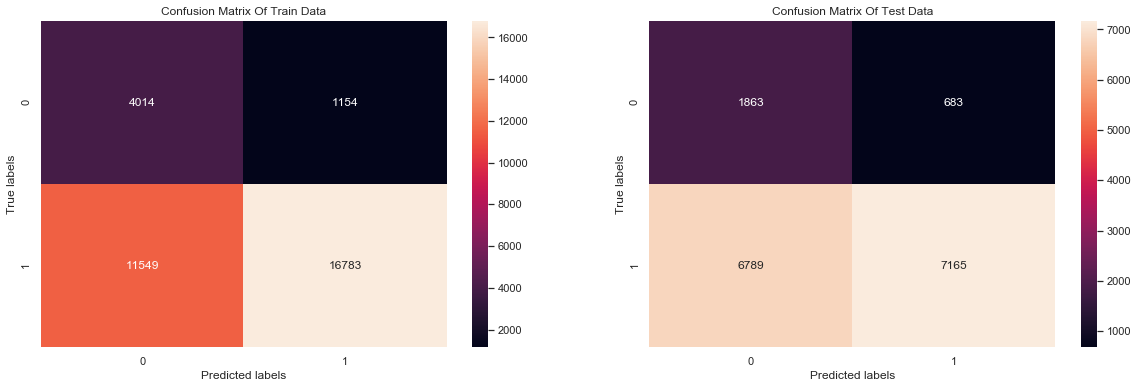

In [150]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(confusion_matrix(y_train,X_train_pred), annot=True, ax = ax[0],fmt='g'); 
#annot=True to annotate cells
# labels, title and ticks
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels');
ax[0].set_title('Confusion Matrix Of Train Data');
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);
sns.heatmap(confusion_matrix(y_test, X_test_pred), annot=True, ax = ax[1],fmt='g'); 
ax[1].set_xlabel('Predicted labels');
ax[1].set_ylabel('True labels');
ax[1].set_title('Confusion Matrix Of Test Data');


### WordCloud plot with Words of essay of false positive data

In [151]:
#Actual vs predicted class labels in Test Data
act_vs_predicted = pd.DataFrame({'index':y_test.index, 'actual':y_test.values,'predicted':X_test_pred})
act_vs_predicted.head()

index  actual  predicted
0  24742       0          1
1  11195       1          1
2  37213       1          0
3  43645       1          0
4  20176       1          1

In [152]:
fpi = []
for i in tqdm(range(len(act_vs_predicted))):
    if(act_vs_predicted['actual'][i]==0 and act_vs_predicted['predicted'][i]==1 ):
        fpi.append(act_vs_predicted['index'][i])

len(fpi)

100%|██████████| 16500/16500 [00:00<00:00, 19906.36it/s]


683

In [153]:
fpi[0:10]

[24742, 11185, 15678, 22520, 6812, 11217, 7591, 43709, 17165, 31742]

In [154]:
# first get the columns:
cols = X_test.columns
X_test_falsePos = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
  X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i], axis=0))

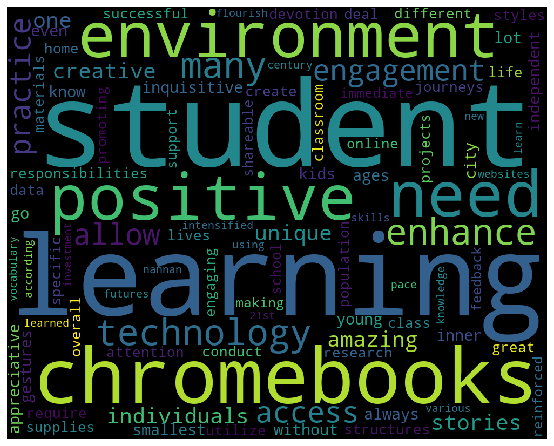

In [87]:
#Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in X_test_falsePos['preprocessed_essays'] :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 1000, height = 800, background_color ='black', stopwords = stopwords,min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Boxplot with price of false positive data

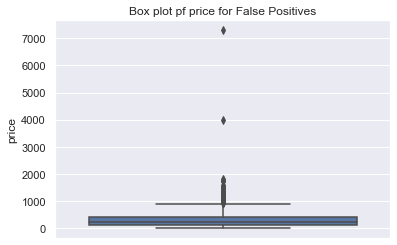

In [88]:
sns.boxplot(y=X_test_falsePos['price'])
plt.title("Box plot pf price for False Positives")
plt.show()

### PDF curve with Teacher_number_of_previously_posted_projects of false positive data

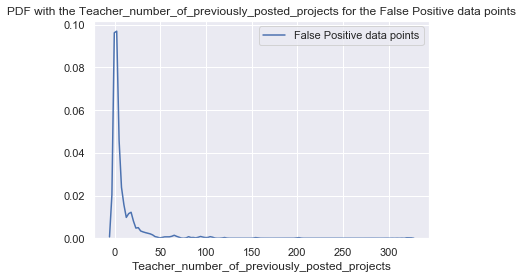

In [89]:
sns.distplot(X_test_falsePos['teacher_number_of_previously_posted_projects'], hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.legend()
plt.show()

### 2.4.2 Applying Descision Tree on TFIDF W2V,<font color='red'> SET 2</font>

In [90]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sea

#best depth in range [1, 5, 10, 50], and the best min_samples_split in range [5, 10, 100, 500]

DT = DecisionTreeClassifier(class_weight = 'balanced')

parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

classifier = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
classifier.fit(X_tr_TFIDF_W2V, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [91]:
print(classifier.cv_results_)

{'mean_fit_time': array([  2.98435028,   3.00028125,   2.95882956,   2.81912573,
        12.69195708,  14.42411677,  14.17324225,  12.51055018,
        38.03548288,  38.98941596,  36.63751189,  22.35750008,
       101.57982302,  98.1078035 ,  85.43425814,  29.14148847]), 'std_fit_time': array([0.05786985, 0.01573334, 0.35728953, 0.13502495, 0.46018537,
       0.88804934, 1.79560244, 0.45890078, 2.35153218, 1.24230068,
       1.02040202, 0.38675319, 7.64264055, 3.48911415, 7.24345282,
       1.23071333]), 'mean_score_time': array([0.07313832, 0.07511957, 0.08510717, 0.07047979, 0.07446694,
       0.09808477, 0.0701472 , 0.07447251, 0.0747985 , 0.08328493,
       0.07663353, 0.0787921 , 0.10091456, 0.097591  , 0.09958736,
       0.08814422]), 'std_score_time': array([0.00448315, 0.00617113, 0.01404173, 0.0026176 , 0.00367181,
       0.01687758, 0.00169409, 0.00678428, 0.00215516, 0.01340939,
       0.00084654, 0.00281929, 0.00295964, 0.01492494, 0.02072768,
       0.00053347]), 'param_ma

In [92]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(classifier.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()
max_scores1

mean_fit_time                                    \
param_max_depth                    1          5          10          50   
param_min_samples_split                                                   
5                            2.984350  12.691957  38.035483  101.579823   
10                           3.000281  14.424117  38.989416   98.107804   
100                          2.958830  14.173242  36.637512   85.434258   
500                          2.819126  12.510550  22.357500   29.141488   

                        std_fit_time                                \
param_max_depth                   1         5         10        50   
param_min_samples_split                                              
5                           0.057870  0.460185  2.351532  7.642641   
10                          0.015733  0.888049  1.242301  3.489114   
100                         0.357290  1.795602  1.020402  7.243453   
500                         0.135025  0.458901  0.386753  1.230713   

                        mean_score_time            ... split2_train_score  \
param_max_depth                      1         5   ...                 10   
param_min_samples_split                            ...                      
5                              0.073138  0.074467  ...           0.879384   
10                             0.075120  0.098085  ...           0.876378   
100                            0.085107  0.070147  ...           0.829342   
500                            0.070480  0.074473  ...           0.753891   

                                  mean_train_score                      \
param_max_depth                50               1         5         10   
param_min_samples_split                                                  
5                        0.999454         0.569785  0.698170  0.881168   
10                       0.998281         0.569785  0.698135  0.878524   
100                      0.925636         0.569785  0.697286  0.834249   
500                      0.771394         0.569785  0.693484  0.755026   

                                  std_train_score                      \
param_max_depth                50              1         5         10   
param_min_samples_split                                                 
5                        0.999570        0.003979  0.003225  0.008782   
10                       0.998593        0.003979  0.003238  0.009234   
100                      0.924528        0.003979  0.004169  0.006506   
500                      0.769239        0.003979  0.003265  0.002434   

                                   
param_max_depth                50  
param_min_samples_split            
5                        0.000093  
10                       0.000296  
100                      0.004494  
500                      0.001708  

[4 rows x 64 columns]

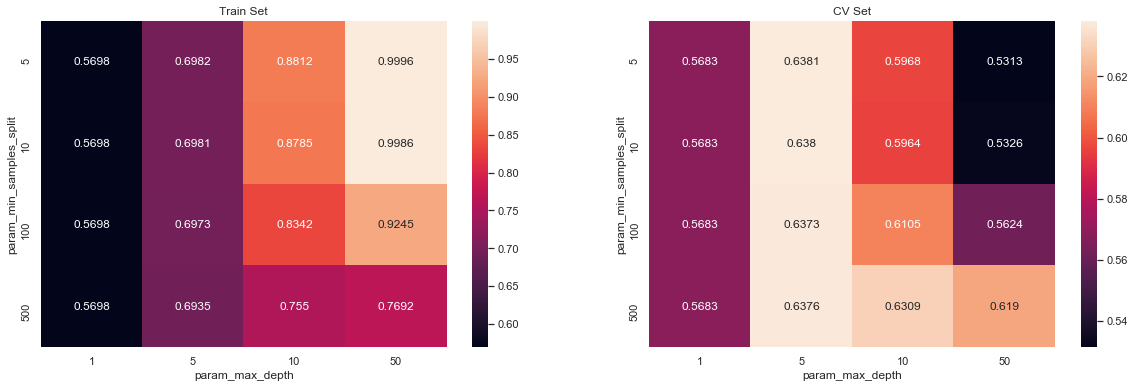

In [93]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [94]:
print(classifier.best_estimator_)
#Mean cross-validated score of the best_estimator
print(classifier.best_params_)
print(classifier.best_score_)
max_d_w2v = classifier.best_params_['max_depth']
min_samp_splt_w2v = classifier.best_params_['min_samples_split']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'max_depth': 5, 'min_samples_split': 5}
0.6381326880683054


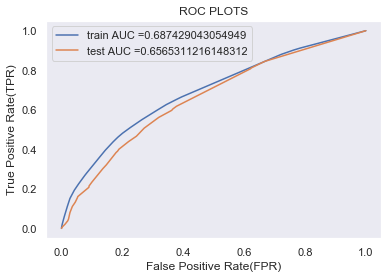

In [95]:
##Fitting Model to Hyper-Parameter Curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
best_clf = DecisionTreeClassifier(class_weight = 'balanced',max_depth=max_d_w2v,min_samples_split=min_samp_splt_w2v)
best_clf.fit(X_tr_TFIDF_W2V ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_clf.predict_proba(X_tr_TFIDF_W2V)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_te_TFIDF_W2V)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.grid(False)
plt.show()

In [96]:
X_train_pred=best_clf.predict(X_tr_TFIDF_W2V)
X_test_pred=best_clf.predict(X_te_TFIDF_W2V)

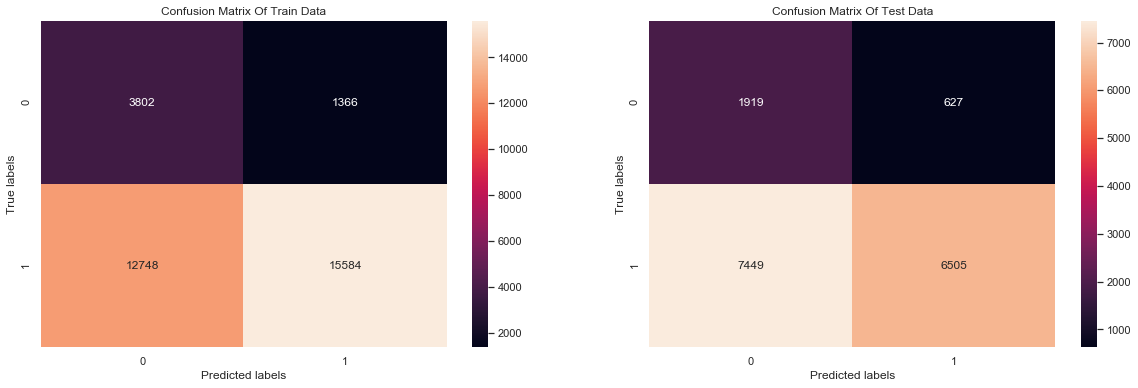

In [97]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(confusion_matrix(y_train, X_train_pred), annot=True, ax = ax[0],fmt='g'); 
#annot=True to annotate cells
# labels, title and ticks
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels');
ax[0].set_title('Confusion Matrix Of Train Data');
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);
sns.heatmap(confusion_matrix(y_test, X_test_pred), annot=True, ax = ax[1],fmt='g'); 
ax[1].set_xlabel('Predicted labels');
ax[1].set_ylabel('True labels');
ax[1].set_title('Confusion Matrix Of Test Data');


### WordCloud plot with Words of essay of false positive data

In [98]:
#Actual vs predicted class labels in Test Data
act_vs_predicted = pd.DataFrame({'index':y_test.index, 'actual':y_test.values,'predicted':X_test_pred})
act_vs_predicted.head()

index  actual  predicted
0  24742       0          1
1  11195       1          0
2  37213       1          0
3  43645       1          0
4  20176       1          0

In [99]:
fpi = []
for i in tqdm(range(len(act_vs_predicted))):
    if(act_vs_predicted['actual'][i]==0 and act_vs_predicted['predicted'][i]==1 ):
        fpi.append(act_vs_predicted['index'][i])

len(fpi)

100%|██████████| 16500/16500 [00:00<00:00, 21169.51it/s]


627

In [100]:
fpi[0:10]

[24742, 15678, 22520, 7591, 43709, 37673, 31742, 9797, 14001, 43486]

In [101]:
# first get the columns:
cols = X_test.columns
X_test_falsePos = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
  X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i], axis=0))

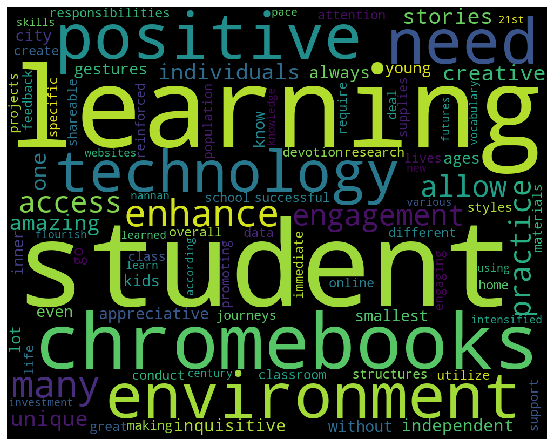

In [102]:
#Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in X_test_falsePos['preprocessed_essays'] :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 1000, height = 800, background_color ='black', stopwords = stopwords,min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Boxplot with price of false positive data

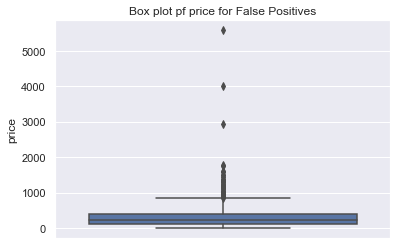

In [103]:
sns.boxplot(y=X_test_falsePos['price'])
plt.title("Box plot pf price for False Positives")
plt.show()

### PDF curve with Teacher_number_of_previously_posted_projects of false positive data

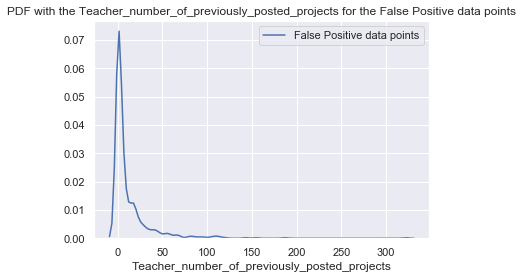

In [104]:
sns.distplot(X_test_falsePos['teacher_number_of_previously_posted_projects'], hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.legend()
plt.show()

<h2>2.5 Getting top features using `feature_importances_`</h2>

In [105]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [171]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=best_clf_TFIDF, threshold = 0.001).fit(X_tr_TFIDF, y_train)

In [172]:
selector.threshold_

0.001

In [173]:
X_tr_TFIDF_updated=selector.transform(X_tr_TFIDF)

In [174]:
X_tr_TFIDF_updated.shape

(33500, 81)

In [175]:
X_te_TFIDF_updated=selector.transform(X_te_TFIDF)

X_te_TFIDF_updated.shape

(16500, 81)

In [176]:
len(best_clf_TFIDF.feature_importances_[best_clf_TFIDF.feature_importances_[:]!=0])

81

In [111]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sea

#best depth in range [1, 5, 10, 50], and the best min_samples_split in range [5, 10, 100, 500]

DT = DecisionTreeClassifier(class_weight = 'balanced')

parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

classifier = GridSearchCV(DT, parameters, cv=3, scoring='roc_auc',return_train_score=True)
classifier.fit(X_tr_TFIDF_updated, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [112]:
print(classifier.cv_results_)

{'mean_fit_time': array([0.12071935, 0.14356351, 0.17763956, 0.13186757, 0.60697389,
       0.69586126, 0.68292745, 0.69334515, 1.46432145, 1.42284695,
       1.22932482, 1.0073518 , 4.59069228, 4.14888851, 2.48693371,
       1.17572355]), 'std_fit_time': array([0.00732422, 0.01175314, 0.02649023, 0.00701675, 0.07261233,
       0.02414188, 0.12033267, 0.17459707, 0.1198064 , 0.01360725,
       0.05898492, 0.07747608, 0.70357609, 0.22955403, 0.23073929,
       0.0257237 ]), 'mean_score_time': array([0.01253144, 0.01098053, 0.01664782, 0.0123148 , 0.01301694,
       0.01602944, 0.01335637, 0.0170087 , 0.01599979, 0.01364772,
       0.01566291, 0.0151693 , 0.01196909, 0.01597579, 0.01063927,
       0.01462873]), 'std_score_time': array([0.00174047, 0.00354177, 0.00126033, 0.00249216, 0.00283598,
       0.00219624, 0.00206775, 0.00717339, 0.00285221, 0.00169745,
       0.00337032, 0.00134472, 0.00081517, 0.00645432, 0.00094032,
       0.00329071]), 'param_max_depth': masked_array(data=[1, 

In [113]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(classifier.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()
max_scores1

mean_fit_time                                \
param_max_depth                    1         5         10        50   
param_min_samples_split                                               
5                            0.120719  0.606974  1.464321  4.590692   
10                           0.143564  0.695861  1.422847  4.148889   
100                          0.177640  0.682927  1.229325  2.486934   
500                          0.131868  0.693345  1.007352  1.175724   

                        std_fit_time                                \
param_max_depth                   1         5         10        50   
param_min_samples_split                                              
5                           0.007324  0.072612  0.119806  0.703576   
10                          0.011753  0.024142  0.013607  0.229554   
100                         0.026490  0.120333  0.058985  0.230739   
500                         0.007017  0.174597  0.077476  0.025724   

                        mean_score_time            ... split2_train_score  \
param_max_depth                      1         5   ...                 10   
param_min_samples_split                            ...                      
5                              0.012531  0.013017  ...           0.801332   
10                             0.010981  0.016029  ...           0.798132   
100                            0.016648  0.013356  ...           0.767585   
500                            0.012315  0.017009  ...           0.740902   

                                  mean_train_score                      \
param_max_depth                50               1         5         10   
param_min_samples_split                                                  
5                        0.998258         0.569785  0.686482  0.801065   
10                       0.991059         0.569785  0.686464  0.797826   
100                      0.887098         0.569785  0.684583  0.771623   
500                      0.780663         0.569785  0.682894  0.741781   

                                  std_train_score                      \
param_max_depth                50              1         5         10   
param_min_samples_split                                                 
5                        0.998276        0.003979  0.002151  0.009203   
10                       0.991074        0.003979  0.002176  0.008458   
100                      0.890015        0.003979  0.002086  0.007859   
500                      0.780041        0.003979  0.001827  0.003619   

                                   
param_max_depth                50  
param_min_samples_split            
5                        0.000292  
10                       0.000351  
100                      0.002240  
500                      0.004248  

[4 rows x 64 columns]

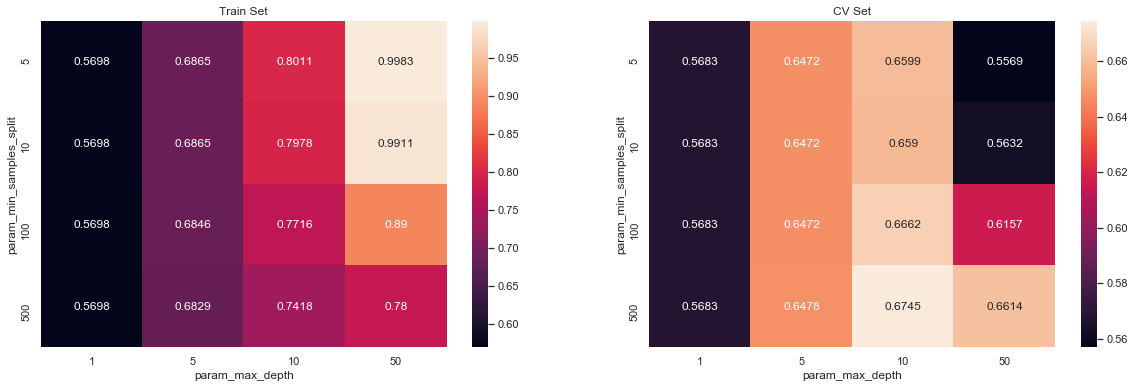

In [114]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [115]:
print(classifier.best_estimator_)
#Mean cross-validated score of the best_estimator
print(classifier.best_params_)
print(classifier.best_score_)
max_d_impft = classifier.best_params_['max_depth']
min_samp_splt_impft = classifier.best_params_['min_samples_split']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'max_depth': 10, 'min_samples_split': 500}
0.6744543242011188


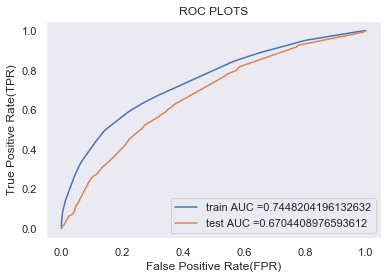

In [116]:
##Fitting Model to Hyper-Parameter Curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
best_clf_TFIDF = DecisionTreeClassifier(class_weight = 'balanced',max_depth=max_d_impft,min_samples_split=min_samp_splt_impft)
best_clf_TFIDF.fit(X_tr_TFIDF_updated ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_clf_TFIDF.predict_proba(X_tr_TFIDF_updated)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_clf_TFIDF.predict_proba(X_te_TFIDF_updated)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.grid(False)
plt.show()

In [117]:
X_train_pred=best_clf_TFIDF.predict(X_tr_TFIDF_updated)
X_test_pred=best_clf_TFIDF.predict(X_te_TFIDF_updated)

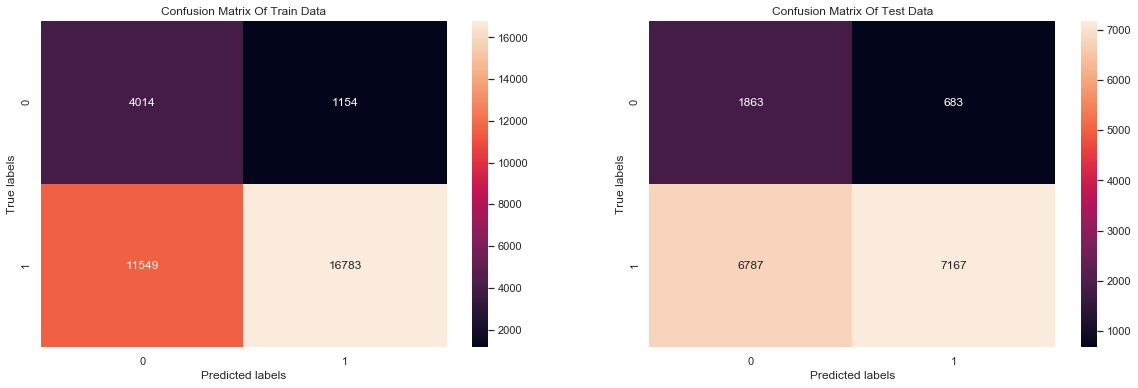

In [118]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(confusion_matrix(y_train, X_train_pred), annot=True, ax = ax[0],fmt='g'); 
#annot=True to annotate cells
# labels, title and ticks
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels');
ax[0].set_title('Confusion Matrix Of Train Data');
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);
sns.heatmap(confusion_matrix(y_test, X_test_pred), annot=True, ax = ax[1],fmt='g'); 
ax[1].set_xlabel('Predicted labels');
ax[1].set_ylabel('True labels');
ax[1].set_title('Confusion Matrix Of Test Data');


### WordCloud plot with Words of essay of false positive data

In [119]:
#Actual vs predicted class labels in Test Data
act_vs_predicted = pd.DataFrame({'index':y_test.index, 'actual':y_test.values,'predicted':X_test_pred})
act_vs_predicted.head()

index  actual  predicted
0  24742       0          1
1  11195       1          1
2  37213       1          0
3  43645       1          0
4  20176       1          1

In [120]:
fpi = []
for i in tqdm(range(len(act_vs_predicted))):
    if(act_vs_predicted['actual'][i]==0 and act_vs_predicted['predicted'][i]==1 ):
        fpi.append(act_vs_predicted['index'][i])

len(fpi)

100%|██████████| 16500/16500 [00:00<00:00, 19812.57it/s]


683

In [121]:
fpi[0:10]

[24742, 11185, 15678, 22520, 6812, 11217, 7591, 43709, 17165, 31742]

In [122]:
# first get the columns:
cols = X_test.columns
X_test_falsePos = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
  X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i], axis=0))

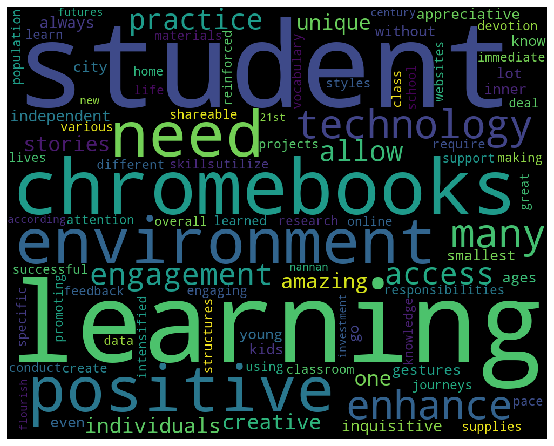

In [123]:
#Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in X_test_falsePos['preprocessed_essays'] :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 1000, height = 800, background_color ='black', stopwords = stopwords,min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Boxplot with price of false positive data

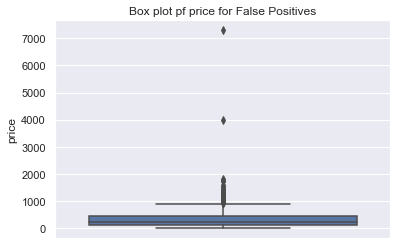

In [124]:
sns.boxplot(y=X_test_falsePos['price'])
plt.title("Box plot pf price for False Positives")
plt.show()

### PDF curve with Teacher_number_of_previously_posted_projects of false positive data

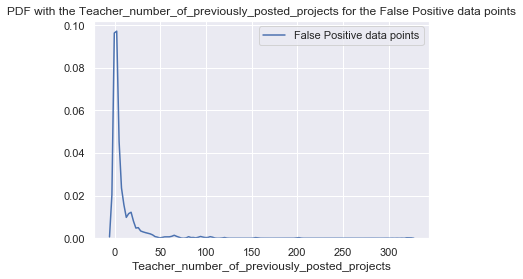

In [125]:
sns.distplot(X_test_falsePos['teacher_number_of_previously_posted_projects'], hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.legend()
plt.show()

<h1>3. Summary</h1>

In [155]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameters(max depth,min samples split)", "AUC"]
x.add_row(["TFIDF", "Decision Tree", (10,500), 0.67])
x.add_row(["TFIDF W2V", "Decision Tree", (5,5), 0.65])
x.add_row(["TFIDF WITH FEATURE IMPORTANCE", "Decision Tree", (10,500), 0.67])
print(x)


+-------------------------------+---------------+----------------------------------------------+------+
|           Vectorizer          |     Model     | Hyperparameters(max depth,min samples split) | AUC  |
+-------------------------------+---------------+----------------------------------------------+------+
|             TFIDF             | Decision Tree |                  (10, 500)                   | 0.67 |
|           TFIDF W2V           | Decision Tree |                    (5, 5)                    | 0.65 |
| TFIDF WITH FEATURE IMPORTANCE | Decision Tree |                  (10, 500)                   | 0.67 |
+-------------------------------+---------------+----------------------------------------------+------+


### Observation

1.With 50k data, we can see that Normal TFIDF and TFIDF WITH FEATURE IMPORTANCE has given highest AUC score 